# **PREDICCIÓN DE VENTAS POR ARTÍCULOS**
# 
# INTEGRANTES:
# 
### LUCIA MONCHIERO GARCIA
### GERMÁN GABRIEL LELOUTRE
### GASTÓN GUILLERMO SAVER

<img src=https://ml-challenge.mercadolibre.com/static/images/logo-mercado-libre_en.png>

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from pmdarima import auto_arima
from pmdarima.arima import ADFTest
import warnings

# Data Acquisition

In [7]:
train_data = pd.read_parquet('train_data.parquet')
print(train_data.shape)
train_data.head()

(37660279, 9)


sku        date  sold_quantity  current_price currency listing_type  \
0  464801  2021-02-01              0         156.78      REA      classic   
1  464801  2021-02-02              0         156.78      REA      classic   
2  464801  2021-02-03              0         156.78      REA      classic   
3  464801  2021-02-04              0         156.78      REA      classic   
4  464801  2021-02-05              1         156.78      REA      classic   

  shipping_logistic_type shipping_payment  minutes_active  
0            fulfillment    free_shipping          1440.0  
1            fulfillment    free_shipping          1440.0  
2            fulfillment    free_shipping          1440.0  
3            fulfillment    free_shipping          1440.0  
4            fulfillment    free_shipping          1440.0

## El Data Frame cuenta con 37M de filas con ventas de Argentina, Brasil, México, etc. por sku, a los efectos entender como funciona un model de serie de tiempo nos vamos a quedar con la base sólo de Argentina

In [15]:
train_data = train_data[train_data['currency'] == 'ARG']
train_data.shape

(3273179, 9)

# Cargar el maestro de productos

In [8]:
items = pd.read_json('items_static_metadata_full.jl', lines=True)
print(items.shape)
items.head()

(660916, 7)


item_domain_id  item_id  \
0         MLB-SNEAKERS   492155   
1  MLB-SURFBOARD_RACKS   300279   
2        MLM-NECKLACES    69847   
3            MLM-RINGS   298603   
4          MLB-WEBCAMS   345949   

                                          item_title site_id  sku product_id  \
0    Tênis Masculino Olympikus Cyber Barato Promoçao     MLB    0       None   
1  Suporte Rack Prancha Parede C/ Regulagem Horiz...     MLB    1       None   
2  5 Collares Plateados Dama Gargantilla Choker -...     MLM    2       None   
3  Lindo Anillo De Bella Crepusculo Twilight Prom...     MLM    3       None   
4  Webcam Com Microfone Hd 720p Knup Youtube Pc V...     MLB    4       None   

  product_family_id  
0       MLB15832732  
1              None  
2              None  
3              None  
4              None

# EDA

In [14]:
# Realizamos primeras tareas de análisis y exploración del dataset
train_data.describe().T     # Resumen de medidas estadísticas

count           mean            std   min            25%  \
sku             3273179.0  330436.849122  190769.206742  10.0  164908.000000   
sold_quantity   3273179.0       0.921937       5.208599   0.0       0.000000   
current_price   3273179.0    4262.202018   85570.953846   8.0     690.000000   
minutes_active  3273179.0    1087.502102     604.815898   0.0     876.111842   

                     50%       75%         max  
sku             331129.0  495885.0    660909.0  
sold_quantity        0.0       1.0      2049.0  
current_price     1599.0    3899.0  29965437.0  
minutes_active    1440.0    1440.0      1440.0

In [16]:
train_data.dtypes   # Resumen del tipo de datos del dataframe

sku                         int64
date                       object
sold_quantity               int64
current_price             float64
currency                   object
listing_type               object
shipping_logistic_type     object
shipping_payment           object
minutes_active            float64
dtype: object

In [17]:
train_data.info()     # Información complementaria del dataframe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3273179 entries, 34387100 to 37660278
Data columns (total 9 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   sku                     int64  
 1   date                    object 
 2   sold_quantity           int64  
 3   current_price           float64
 4   currency                object 
 5   listing_type            object 
 6   shipping_logistic_type  object 
 7   shipping_payment        object 
 8   minutes_active          float64
dtypes: float64(2), int64(2), object(5)
memory usage: 249.7+ MB


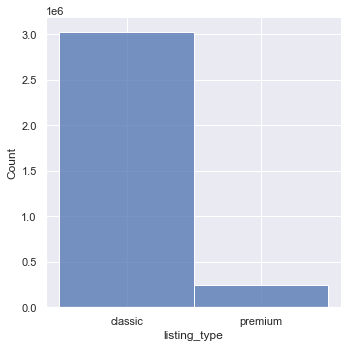

In [18]:
# Variable listing_type
sns.set_theme()
ax = sns.displot(data=train_data, x='listing_type')

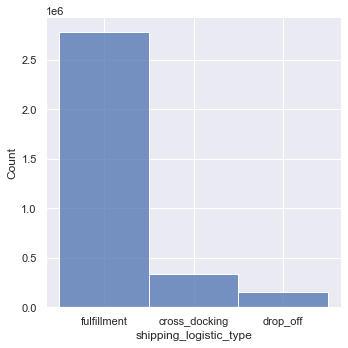

In [19]:
# Variable shipping_logistic_type
sns.set_theme()
ax = sns.displot(data=train_data, x='shipping_logistic_type')

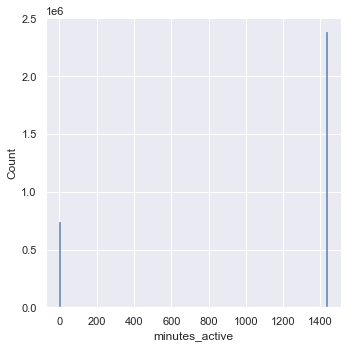

In [20]:
# Variable minutes_active
sns.set_theme()
ax = sns.displot(data=train_data, x='minutes_active')

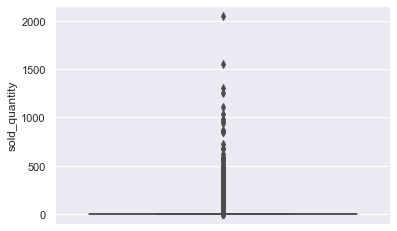

In [21]:
sns.set_theme()
ax = sns.boxplot(data=train_data, y='sold_quantity')

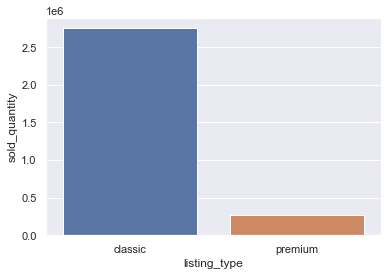

In [22]:
# Ventas por tipo de publicación
ax = sns.barplot(data=train_data.groupby('listing_type')['sold_quantity'].sum().reset_index(name='sold_quantity'), x='listing_type', y='sold_quantity')

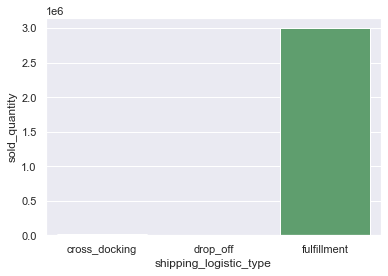

In [23]:
# Ventas por tipo de envío
ax = sns.barplot(data=train_data.groupby('shipping_logistic_type')['sold_quantity'].sum().reset_index(name='sold_quantity'), x='shipping_logistic_type', y='sold_quantity')  

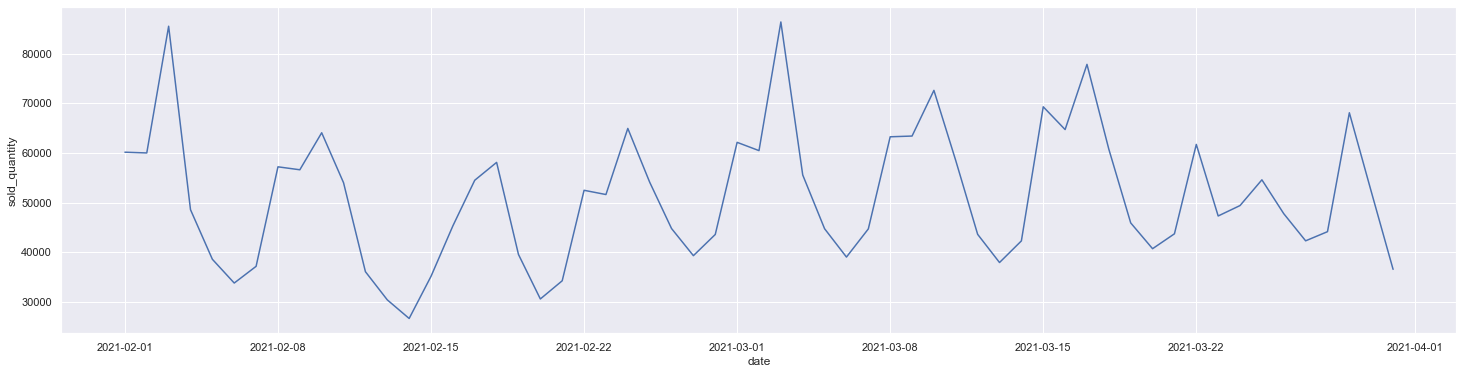

In [56]:
# Ventas por día
plt.figure(figsize=(25,6))
ax = sns.lineplot(data=train_data.groupby('date')['sold_quantity'].sum().reset_index(name='sold_quantity'), x='date', y='sold_quantity')

In [25]:
train_data.corr()

sku  sold_quantity  current_price  minutes_active
sku             1.000000       0.000492       0.000937       -0.000322
sold_quantity   0.000492       1.000000      -0.001341        0.090053
current_price   0.000937      -0.001341       1.000000       -0.007828
minutes_active -0.000322       0.090053      -0.007828        1.000000

In [27]:
# Pasar columnas categóricas a númericas
df2 = pd.get_dummies(train_data[["listing_type", "shipping_logistic_type", "shipping_payment"]])
train_data_dummies = pd.concat([train_data[["sku", "date", "sold_quantity", "current_price", "minutes_active"]], df2], axis=1)
train_data_dummies.head()

sku        date  sold_quantity  current_price  minutes_active  \
34387100  335582  2021-02-01              6          620.0          1440.0   
34387101  335582  2021-02-02              0          620.0          1440.0   
34387102  335582  2021-02-03              4          620.0          1440.0   
34387103  335582  2021-02-04              0          620.0          1440.0   
34387104  335582  2021-02-05              6          620.0          1440.0   

          listing_type_classic  listing_type_premium  \
34387100                     1                     0   
34387101                     1                     0   
34387102                     1                     0   
34387103                     1                     0   
34387104                     1                     0   

          shipping_logistic_type_cross_docking  \
34387100                                     0   
34387101                                     0   
34387102                                     0   
34387103                                     0   
34387104                                     0   

          shipping_logistic_type_drop_off  shipping_logistic_type_fulfillment  \
34387100                                0                                   1   
34387101                                0                                   1   
34387102                                0                                   1   
34387103                                0                                   1   
34387104                                0                                   1   

          shipping_payment_free_shipping  shipping_payment_paid_shipping  
34387100                               0                               1  
34387101                               0                               1  
34387102                               0                               1  
34387103                               0                               1  
34387104                               0                               1

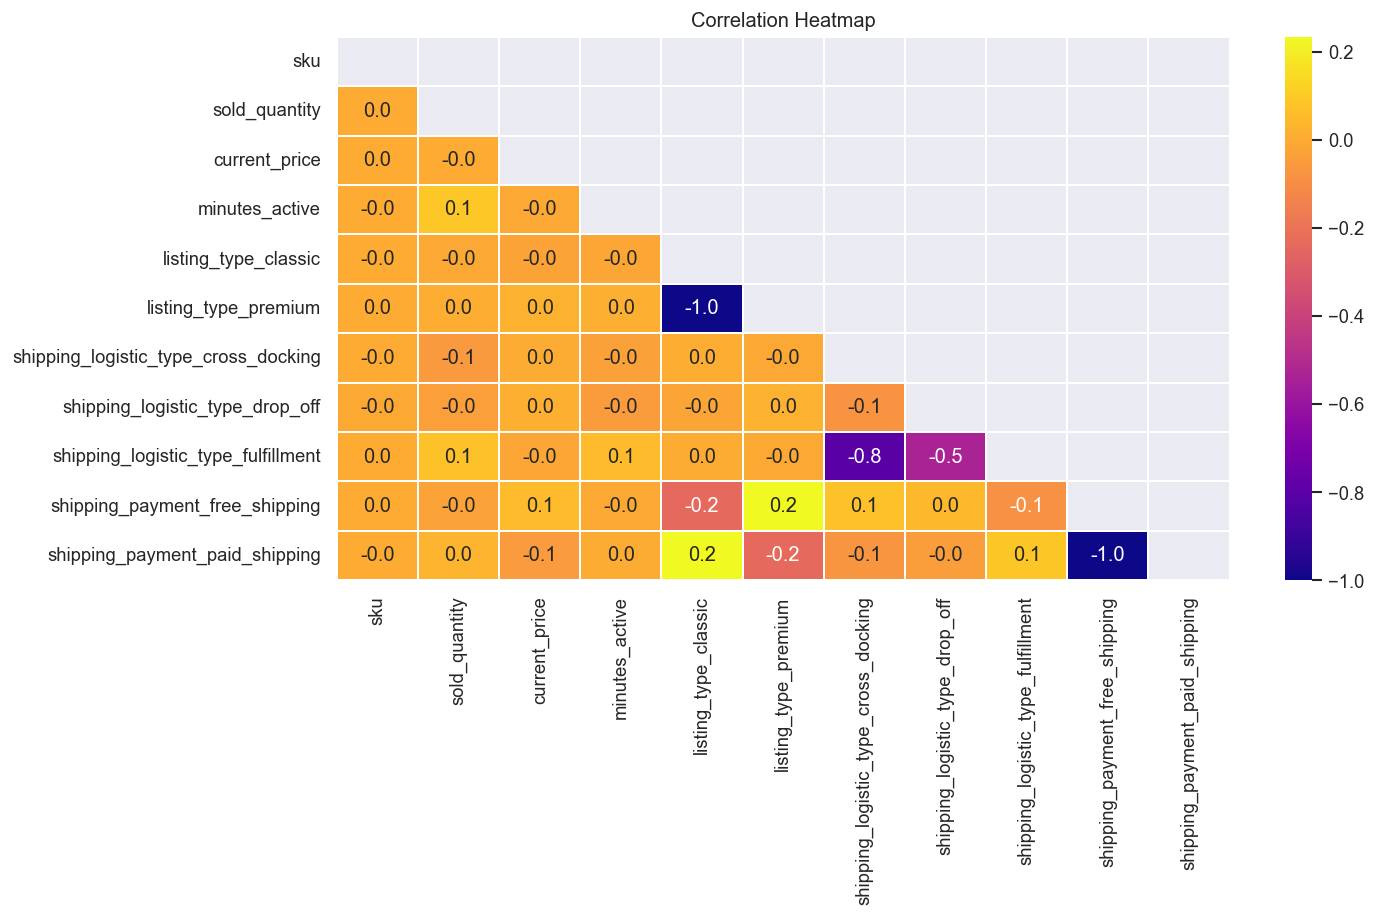

In [29]:
#Correlaciones
plt.figure(dpi = 120, figsize= (12,6))
mask = np.triu(np.ones_like(train_data_dummies.corr(), dtype = bool))
sns.heatmap(train_data_dummies.corr(), mask = mask, fmt = ".1f", annot=True, lw=1, cmap = 'plasma')
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.title('Correlation Heatmap')
plt.show()

### Eliminar variables que no serán utilizadas

In [30]:
# Eliminamos columnas innecesarias del df y filtramos las filas para enfocarnos en Argentina // Convertimos la columna date a datetime
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.drop(columns=['current_price', 'currency', 'listing_type', 'shipping_logistic_type', 'shipping_payment', 'minutes_active'], inplace=True)
print(train_data.dtypes)
train_data.head()

sku                       int64
date             datetime64[ns]
sold_quantity             int64
dtype: object


sku       date  sold_quantity
34387100  335582 2021-02-01              6
34387101  335582 2021-02-02              0
34387102  335582 2021-02-03              4
34387103  335582 2021-02-04              0
34387104  335582 2021-02-05              6

In [31]:
# Nos quedamos con una muestra de los sku de Argentina
items = items[items["site_id"] == 'MLA']
items = items[['item_title', 'item_id', 'sku']]
items = items.sample(n=2000)
items.shape

(2000, 3)

# Análisis de las ventas en el tiempo

## En base a los dos meses de información histórica brindados por Mercadolibre analizamos el comportamiento en un gráfico

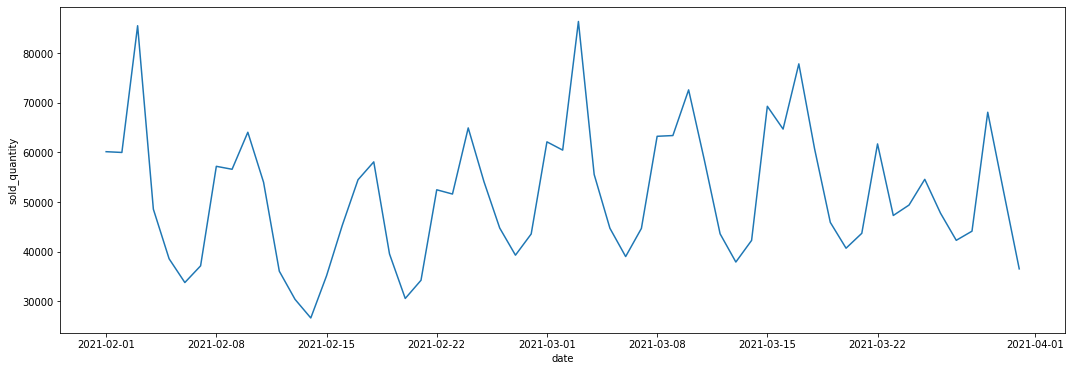

In [210]:
# Ventas por día
plt.figure(figsize=(18,6))
ax = sns.lineplot(data=train_data.groupby('date')['sold_quantity'].sum().reset_index(name='sold_quantity'), x='date', y='sold_quantity')

# Crear la serie de tiempo

## Si bien el dataset muestra las ventas por día por sku, a los efectos de ejecutar un primer análsis agrupamos las ventas por día

In [32]:
series = train_data.groupby('date')['sold_quantity'].sum()
series.head()


date
2021-02-01    60141
2021-02-02    59987
2021-02-03    85528
2021-02-04    48553
2021-02-05    38558
Name: sold_quantity, dtype: int64

# Prueba de estacionariedad

In [33]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(series)

(0.01, False)

# Train and Test split

## Dividir el dataset en entrenamiento y test

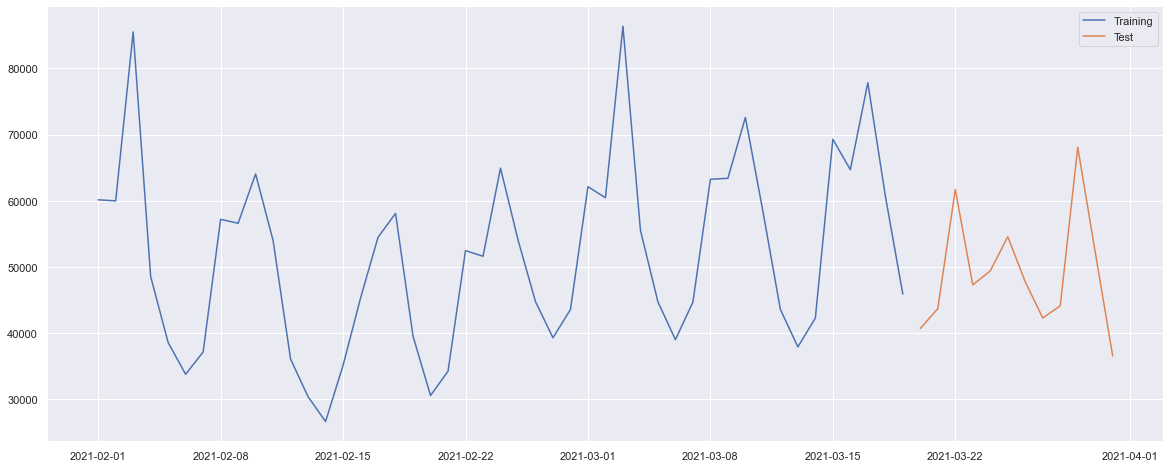

In [34]:
X = series
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

plt.figure(figsize=(20,8))
plt.plot(train, label='Training')
plt.plot(test, label='Test')
plt.legend()
plt.show()


# Construir un modelo Auto Arima

In [35]:
autoarima_model = auto_arima(train, start_p=0, d=0, start_q=0, max_p=20, max_d=20, max_q=20, start_P=0, D=1, start_Q=0, max_P=20, max_D=20, max_Q=20, m=7, seasonal=True, error_action='warn', trace=True, random_state=20, n_fits=100, suppress_warnings=True, stepwise=False, method='nm')

 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=842.647, Time=0.06 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=832.343, Time=0.04 sec
 ARIMA(0,0,0)(0,1,2)[7] intercept   : AIC=837.613, Time=0.05 sec
 ARIMA(0,0,0)(0,1,3)[7] intercept   : AIC=835.570, Time=0.06 sec
 ARIMA(0,0,0)(0,1,4)[7] intercept   : AIC=840.200, Time=0.07 sec
 ARIMA(0,0,0)(0,1,5)[7] intercept   : AIC=844.516, Time=0.10 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : AIC=838.205, Time=0.04 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=827.784, Time=0.04 sec
 ARIMA(0,0,0)(1,1,2)[7] intercept   : AIC=829.308, Time=0.04 sec
 ARIMA(0,0,0)(1,1,3)[7] intercept   : AIC=840.586, Time=0.06 sec
 ARIMA(0,0,0)(1,1,4)[7] intercept   : AIC=845.632, Time=0.08 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=826.575, Time=0.04 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : AIC=827.487, Time=0.04 sec
 ARIMA(0,0,0)(2,1,2)[7] intercept   : AIC=840.917, Time=0.05 sec
 ARIMA(0,0,0)(2,1,3)[7] intercept   : AIC=847.322, Time=0.06 sec
 ARIMA(0,0,0)(3,1,0)[7] i

# Resumen del modelo

In [36]:
autoarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   47
Model:             SARIMAX(0, 0, 2)x(2, 1, [], 7)   Log Likelihood                -404.590
Date:                            Wed, 17 Nov 2021   AIC                            821.180
Time:                                    12:26:52   BIC                            831.313
Sample:                                         0   HQIC                           824.844
                                             - 47                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2047.5955   2147.085      0.954      0.340   -2160.614    6255.805
ma.L1          0.2347      0.219      1.074      0.283      -0.194       0.663
ma.L2          0.2625      0.226      1.161      0.246      -0.181       0.706
ar.S.L7       -0.2561      0.085     -2.998      0.003      -0.424      -0.089
ar.S.L14      -0.2247      0.058     -3.907      0.000      -0.337      -0.112
sigma2      3.596e+07      0.316   1.14e+08      0.000     3.6e+07     3.6e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.86
Prob(Q):                              1.00   Prob(JB):                         0.24
Heteroskedasticity (H):               0.34   Skew:                             0.42
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.77e+24. Standard errors may be unstable.
"""

# Comparar lo real vs. lo predecido

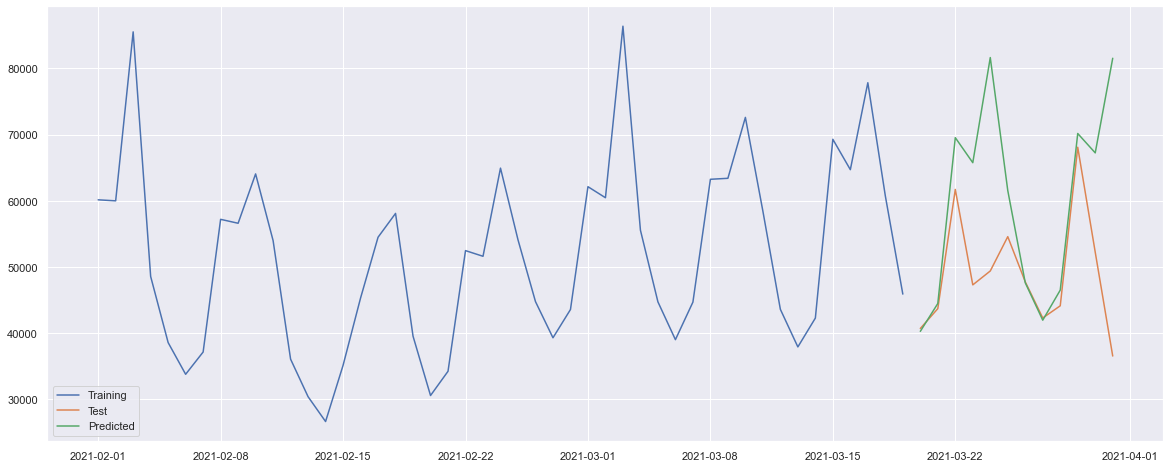

In [37]:
prediction = pd.DataFrame(autoarima_model.predict(n_periods=12), index=test.index)
prediction.columns = ['predicted_sales']

plt.figure(figsize=(20,8))
plt.plot(train, label="Training")
plt.plot(test, label="Test")
plt.plot(prediction, label="Predicted")
plt.legend()
plt.show()

278816 Tira Luces Led Rgb Multicolor Interior Auto 12v Audioritmica
RMSE: 0.848
54582 Sierra Caladora Black+decker 420w 3000cpm Ks501
Información histórica de ventas incompleta
628287  Catan Original Devir - Juego De Mesa - Invictvs
RMSE: 2.138
429737 Auriculares In-ear Apple Earpods Blanco
RMSE: 1.501
414465 Micrófono Fifine F-800 Condensador  Negro
RMSE: 0.674
314853 Correa Guitarra Bajo Hipstrap Kashmir Gold Vintage Paisley
RMSE: 0.475
277651 Auriculares Manos Libres Microfono Cable Largo Resistente 
RMSE: 0.403
584987 Inexpulsable + Joya Plug Anal + Gel Sextual De Regalo
RMSE: 1.307
5008 Electrovalvula Variador Fase Arbol Levas Cruze Tracker Sonic
RMSE: 0.819
289718 Hilado Cashmilon Nube Soft 2/7 X 10 Ovillos - 1 Kg Por Color
RMSE: 0.434
481674 Bolsa De Boxeo 0,90m   Uso Profesional (sin Relleno)
RMSE: 1.126
379595 Cafe En Capsulas La Morenita Espresso Etiopia 10 Capsulas
RMSE: 3.192
321692 Celular Libre LG K50s 32gb 3gb Ram Nuevo Garantia
RMSE: 0.986
437635 Detergente Para Lavavaj

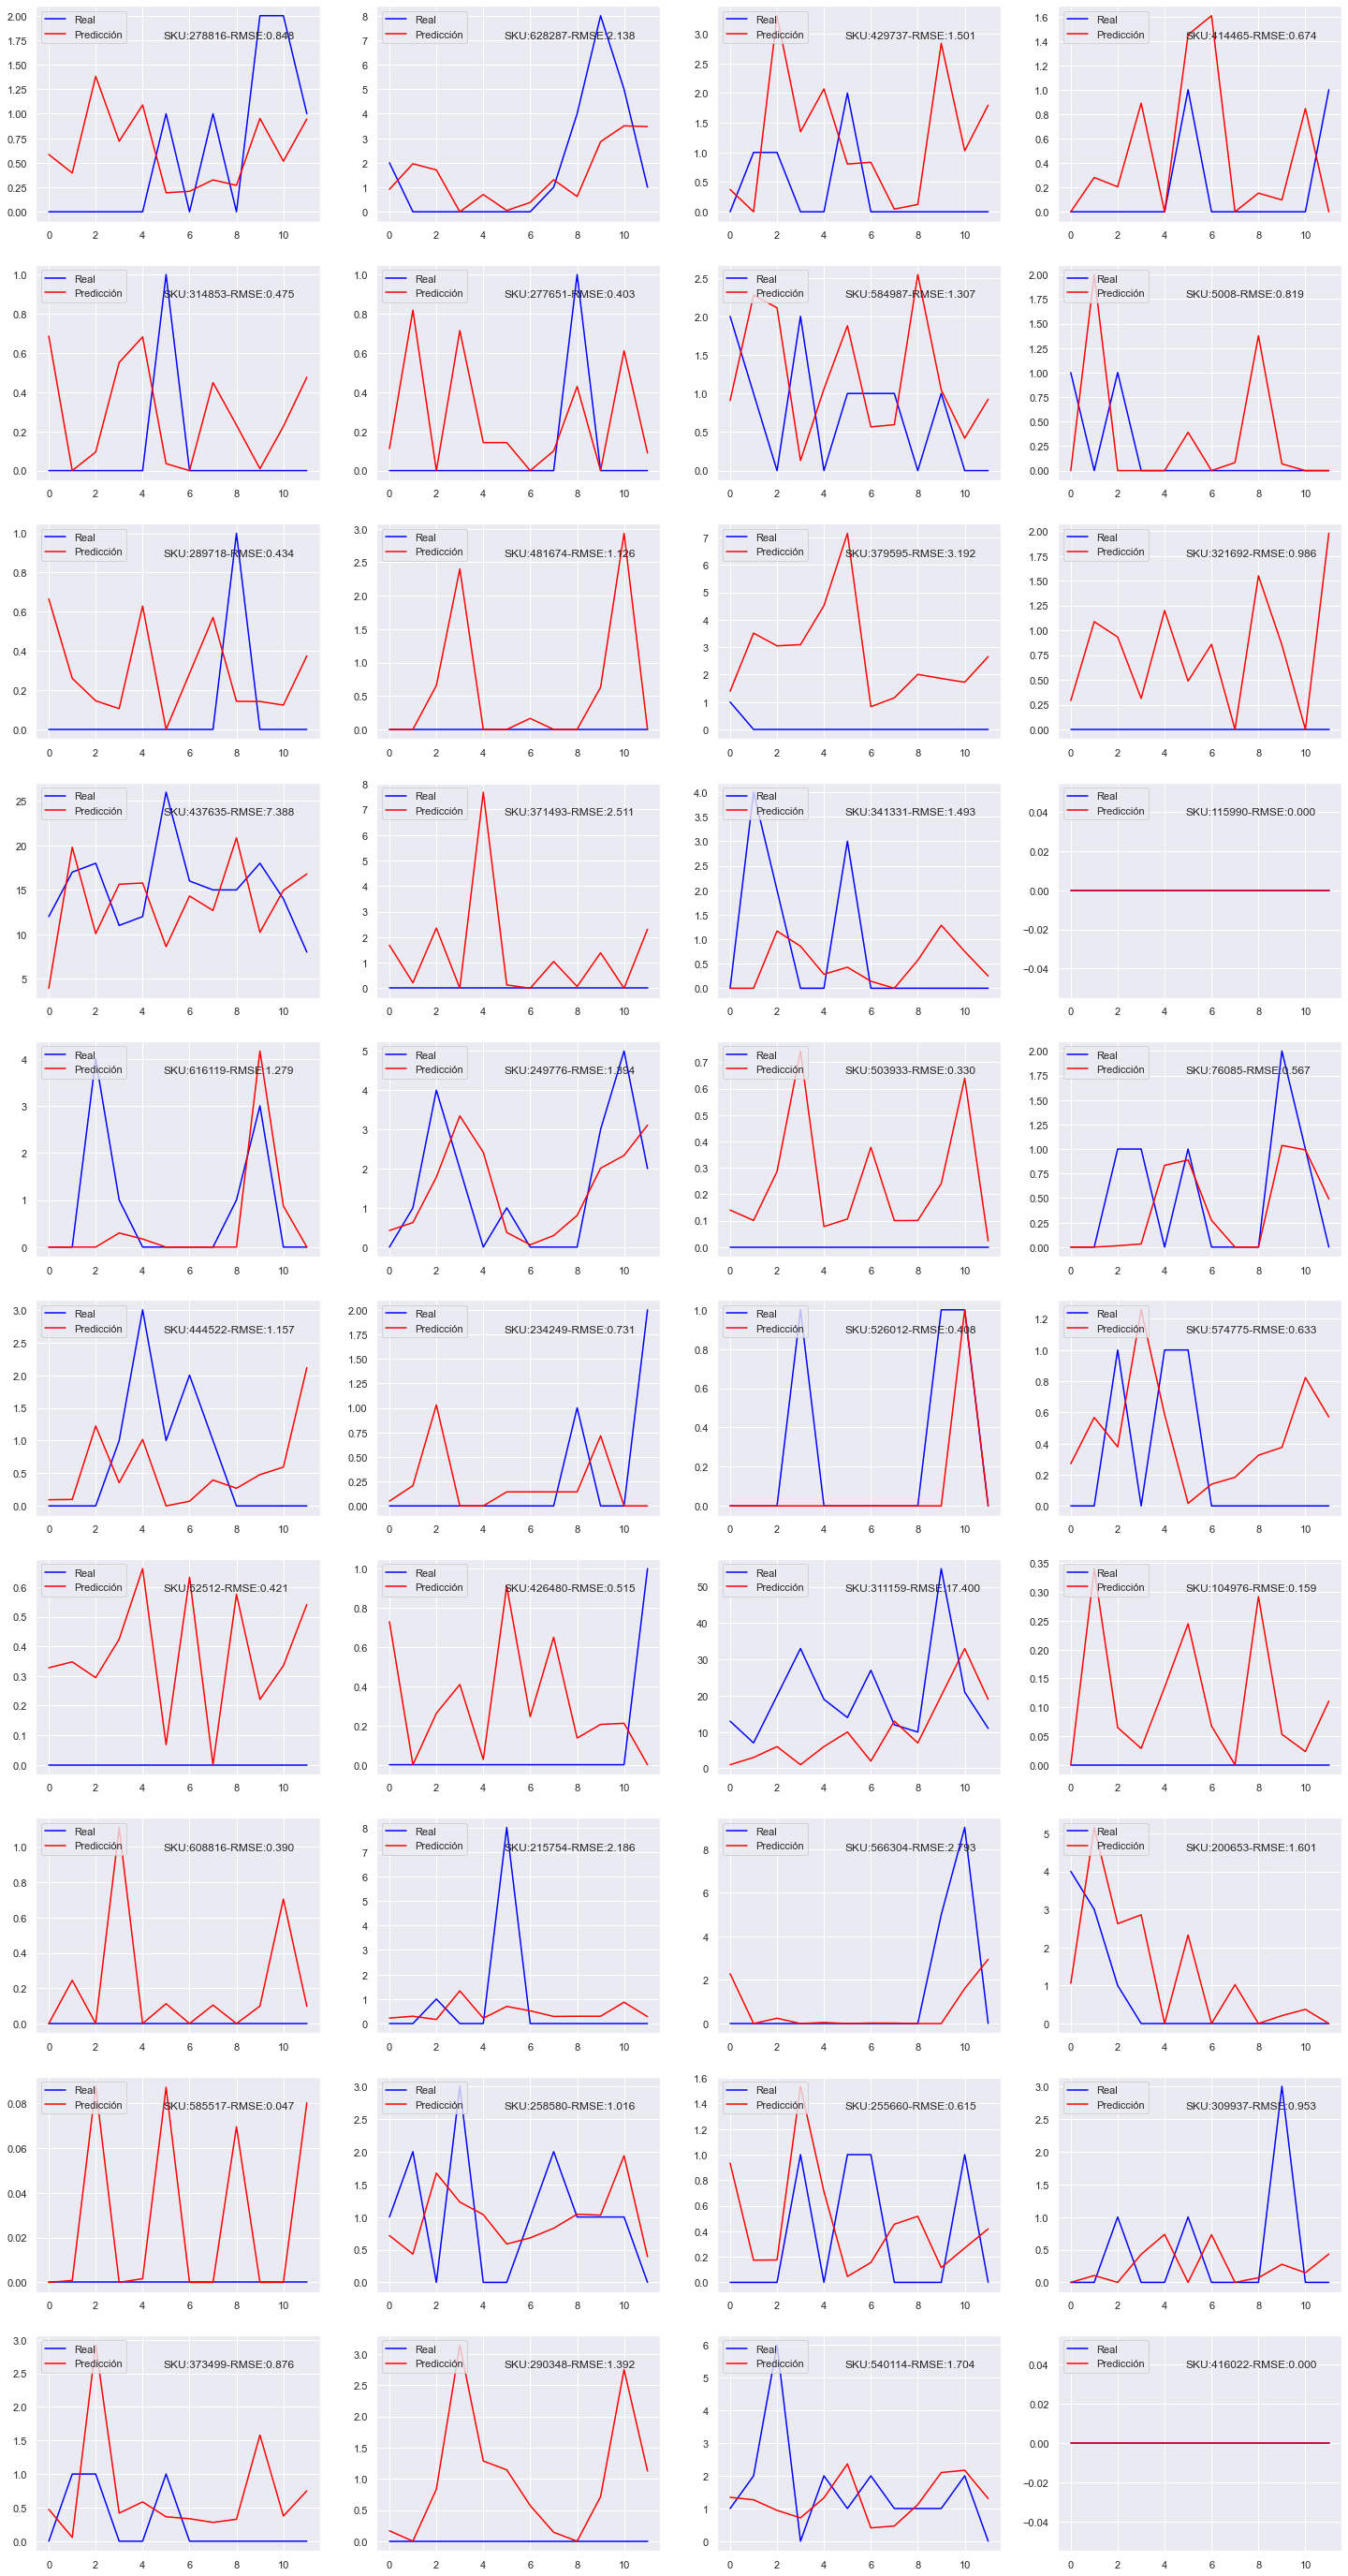

In [40]:
warnings.filterwarnings("ignore")

vuelta = 0
n_skus = 0

# Iterar cada SKU del dataframe de stock
fig, ax1= plt.subplots(nrows = 10, ncols = 4, figsize=(25,50))
yi = 0
for index, row in items.iterrows():
    
    sku = row['sku']
    print(sku, row['item_title'])
    
    # filtrar el dataframe de entrenamiento para cada sku y creamos nuevas series de tiempo para cada sku
    series = train_data[train_data['sku'] == sku]
    
    # Descartar todos los sku que no tienen la info histórica completa
    if series.shape[0] != 59:
        print('Información histórica de ventas incompleta')
        continue
    
    series.set_index('date', inplace=True)
    series = series['sold_quantity']
        
    # Dividir los datos en entrenamiento y test
    X = np.array(series)
    size = int(len(X) * 0.8)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    
    # Autoconfigurar el mejor modelo arima para la serie de tiempo de cada sku
    autoarima_model = auto_arima(series, start_p=0, d=0, start_q=0, max_p=10, max_d=10, max_q=10, start_P=0, D=1, start_Q=0, max_P=10, max_D=10, max_Q=10, m=7, seasonal=True, error_action='warn', trace=False, random_state=20, n_fits=50, suppress_warnings=True, stepwise=True, method='nm')
    
    # Capturar del modelo automático los parametros order y seasonal order
    order = autoarima_model.order
    s_order = autoarima_model.seasonal_order
    
    for t in range(len(test)):
        model = SARIMAX(history, order=order, seasonal_order=s_order, initialization='approximate_diffuse')
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        if yhat < 0:
            yhat = 0
        elif np.isnan(yhat):
            yhat = 0
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        # print('predicted=%f, expected=%f' % (yhat, obs))
    
    # Evaluar lo pronosticado
    rmse = sqrt(mean_squared_error(test, predictions))
    print('RMSE: %.3f' % rmse)

    # Graficar las ventas reales vs. las predecidas
    plt.subplot(10, 4, 1 + yi)
    plt.plot(test, color='blue', label='Real')
    plt.plot(predictions, color='red', label='Predicción')
    plt.legend(loc ='upper left')
    plt.text(0.45, 0.85,'SKU:%d-RMSE:%.3f' %(sku, rmse),
             transform=plt.gca().transAxes)
    yi += 1
    
    # Pronosticar la venta de los x días siguientes
    forecast = model_fit.forecast(12, alpha=0.05)
    ttl = 0
    days = 0

    n_skus += 1
    # A efectos gráficos cuando llegamos a los 40 sku salimos
    if n_skus >= 40:
        break

# Clusterización de series de tiempo

In [41]:
import tslearn

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from tslearn.clustering import TimeSeriesKMeans 
from tslearn import metrics

import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [42]:
train_data.head()
df = pd.merge(left=train_data, right=items, how='inner')
print(df.shape)
df.head()

(112729, 5)


sku       date  sold_quantity  \
0  133940 2021-02-01              0   
1  133940 2021-02-02              0   
2  133940 2021-02-03              0   
3  133940 2021-02-04              0   
4  133940 2021-02-05              0   

                                          item_title  item_id  
0  Bicicleta Mountain Bike Rodado 26 Doble Suspen...   347552  
1  Bicicleta Mountain Bike Rodado 26 Doble Suspen...   347552  
2  Bicicleta Mountain Bike Rodado 26 Doble Suspen...   347552  
3  Bicicleta Mountain Bike Rodado 26 Doble Suspen...   347552  
4  Bicicleta Mountain Bike Rodado 26 Doble Suspen...   347552

In [43]:
train_data.dtypes

sku                       int64
date             datetime64[ns]
sold_quantity             int64
dtype: object

In [44]:
selected_skus = df['sku'].value_counts().reset_index(name="count")["index"]
selected_skus

0       133940
1       453788
2       371493
3       345870
4        59187
         ...  
1995    209449
1996    587658
1997    442828
1998    399195
1999    329525
Name: index, Length: 2000, dtype: int64

In [45]:
df_filtered = df[df['sku'].isin(selected_skus)]
df_filtered.head()

sku       date  sold_quantity  \
0  133940 2021-02-01              0   
1  133940 2021-02-02              0   
2  133940 2021-02-03              0   
3  133940 2021-02-04              0   
4  133940 2021-02-05              0   

                                          item_title  item_id  
0  Bicicleta Mountain Bike Rodado 26 Doble Suspen...   347552  
1  Bicicleta Mountain Bike Rodado 26 Doble Suspen...   347552  
2  Bicicleta Mountain Bike Rodado 26 Doble Suspen...   347552  
3  Bicicleta Mountain Bike Rodado 26 Doble Suspen...   347552  
4  Bicicleta Mountain Bike Rodado 26 Doble Suspen...   347552

In [46]:

# Normalizar la columna de ventas antes de pasarlo por el clusterizador
scaler = MinMaxScaler()
df['scaled_sales'] = scaler.fit_transform(df['sold_quantity'].values.reshape(-1,1))
df_pivot = df.reset_index().pivot_table(index='date', columns='sku', values='scaled_sales', aggfunc = 'sum')
#Transposing
df_pivot = df_pivot.T
df_pivot.fillna(0, inplace=True)
print(df_pivot.shape)
df_pivot.head()

(2000, 59)


date  2021-02-01  2021-02-02  2021-02-03  2021-02-04  2021-02-05  2021-02-06  \
sku                                                                            
10      0.000000         0.0    0.000000    0.000000    0.000000    0.000000   
332     0.000000         0.0    0.000000    0.000000    0.000000    0.000000   
985     0.000000         0.0    0.003891    0.000000    0.003891    0.007782   
1326    0.003891         0.0    0.003891    0.007782    0.000000    0.000000   
1694    0.000000         0.0    0.000000    0.000000    0.000000    0.000000   

date  2021-02-07  2021-02-08  2021-02-09  2021-02-10  ...  2021-03-22  \
sku                                                   ...               
10      0.000000    0.000000    0.000000    0.000000  ...    0.003891   
332     0.000000    0.000000    0.000000    0.000000  ...    0.000000   
985     0.019455    0.003891    0.000000    0.000000  ...    0.007782   
1326    0.011673    0.003891    0.003891    0.007782  ...    0.003891   
1694    0.000000    0.003891    0.000000    0.003891  ...    0.000000   

date  2021-03-23  2021-03-24  2021-03-25  2021-03-26  2021-03-27  2021-03-28  \
sku                                                                            
10           0.0    0.000000         0.0         0.0         0.0    0.000000   
332          0.0    0.003891         0.0         0.0         0.0    0.003891   
985          0.0    0.000000         0.0         0.0         0.0    0.007782   
1326         0.0    0.000000         0.0         0.0         0.0    0.000000   
1694         0.0    0.000000         0.0         0.0         0.0    0.000000   

date  2021-03-29  2021-03-30  2021-03-31  
sku                                       
10      0.000000    0.000000         0.0  
332     0.000000    0.000000         0.0  
985     0.027237    0.007782         0.0  
1326    0.000000    0.003891         0.0  
1694    0.000000    0.000000         0.0  

[5 rows x 59 columns]

# Dynamic time warping - Time series clustering

In [48]:
seed = 0
np.random.seed(seed)

plt.figure(figsize=(20,15))
sz = df_pivot.shape[1]

# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=100,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(df_pivot)
df_pivot['cluster'] = y_pred
df_pivot.head(10)

DBA k-means
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 12000 out of 12000 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 12000 out of 12000 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 12000 out of 12000 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 12000 out of 12000 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 12000 out of 12000 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent 

0.001 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200000 out of 200000 | elapsed:   51.7s finished


0.000 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200000 out of 200000 | elapsed:   51.0s finished


0.000 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200000 out of 200000 | elapsed:   50.5s finished


0.000 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200000 out of 200000 | elapsed:   50.5s finished


0.000 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200000 out of 200000 | elapsed:   50.5s finished


0.000 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 12000 out of 12000 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 12000 out of 12000 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 12000 out of 12000 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 12000 out of 12000 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 12000 out of 12000 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent 

0.001 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200000 out of 200000 | elapsed:   49.8s finished


0.000 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200000 out of 200000 | elapsed:   51.5s finished


0.000 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200000 out of 200000 | elapsed:   49.4s finished


0.000 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200000 out of 200000 | elapsed:   50.0s finished


date  2021-02-01 00:00:00  2021-02-02 00:00:00  2021-02-03 00:00:00  \
sku                                                                   
10               0.000000             0.000000             0.000000   
332              0.000000             0.000000             0.000000   
985              0.000000             0.000000             0.003891   
1326             0.003891             0.000000             0.003891   
1694             0.000000             0.000000             0.000000   
1880             0.000000             0.003891             0.000000   
2100             0.003891             0.000000             0.000000   
2227             0.000000             0.000000             0.000000   
2698             0.000000             0.000000             0.000000   
3367             0.000000             0.000000             0.000000   

date  2021-02-04 00:00:00  2021-02-05 00:00:00  2021-02-06 00:00:00  \
sku                                                                   
10               0.000000             0.000000             0.000000   
332              0.000000             0.000000             0.000000   
985              0.000000             0.003891             0.007782   
1326             0.007782             0.000000             0.000000   
1694             0.000000             0.000000             0.000000   
1880             0.000000             0.000000             0.003891   
2100             0.000000             0.000000             0.000000   
2227             0.007782             0.000000             0.000000   
2698             0.000000             0.000000             0.000000   
3367             0.000000             0.000000             0.000000   

date  2021-02-07 00:00:00  2021-02-08 00:00:00  2021-02-09 00:00:00  \
sku                                                                   
10               0.000000             0.000000             0.000000   
332              0.000000             0.000000             0.000000   
985              0.019455             0.003891             0.000000   
1326             0.011673             0.003891             0.003891   
1694             0.000000             0.003891             0.000000   
1880             0.003891             0.003891             0.000000   
2100             0.000000             0.000000             0.000000   
2227             0.003891             0.000000             0.000000   
2698             0.000000             0.000000             0.000000   
3367             0.000000             0.000000             0.000000   

date  2021-02-10 00:00:00  ...  2021-03-23 00:00:00  2021-03-24 00:00:00  \
sku                        ...                                             
10               0.000000  ...                  0.0             0.000000   
332              0.000000  ...                  0.0             0.003891   
985              0.000000  ...                  0.0             0.000000   
1326             0.007782  ...                  0.0             0.000000   
1694             0.003891  ...                  0.0             0.000000   
1880             0.003891  ...                  0.0             0.000000   
2100             0.000000  ...                  0.0             0.000000   
2227             0.000000  ...                  0.0             0.011673   
2698             0.000000  ...                  0.0             0.000000   
3367             0.000000  ...                  0.0             0.000000   

date  2021-03-25 00:00:00  2021-03-26 00:00:00  2021-03-27 00:00:00  \
sku                                                                   
10               0.000000             0.000000                  0.0   
332              0.000000             0.000000                  0.0   
985              0.000000             0.000000                  0.0   
1326             0.000000             0.000000                  0.0   
1694             0.000000             0.000000                  0.0   
1880             0.000000      

<Figure size 1440x1080 with 0 Axes>

In [49]:
df_pivot

date    2021-02-01 00:00:00  2021-02-02 00:00:00  2021-02-03 00:00:00  \
sku                                                                     
10                 0.000000             0.000000             0.000000   
332                0.000000             0.000000             0.000000   
985                0.000000             0.000000             0.003891   
1326               0.003891             0.000000             0.003891   
1694               0.000000             0.000000             0.000000   
...                     ...                  ...                  ...   
659232             0.000000             0.003891             0.007782   
659559             0.000000             0.003891             0.000000   
659762             0.003891             0.000000             0.000000   
660309             0.000000             0.000000             0.000000   
660824             0.000000             0.000000             0.000000   

date    2021-02-04 00:00:00  2021-02-05 00:00:00  2021-02-06 00:00:00  \
sku                                                                     
10                 0.000000             0.000000             0.000000   
332                0.000000             0.000000             0.000000   
985                0.000000             0.003891             0.007782   
1326               0.007782             0.000000             0.000000   
1694               0.000000             0.000000             0.000000   
...                     ...                  ...                  ...   
659232             0.000000             0.000000             0.000000   
659559             0.003891             0.000000             0.007782   
659762             0.000000             0.000000             0.000000   
660309             0.000000             0.000000             0.000000   
660824             0.000000             0.000000             0.000000   

date    2021-02-07 00:00:00  2021-02-08 00:00:00  2021-02-09 00:00:00  \
sku                                                                     
10                 0.000000             0.000000             0.000000   
332                0.000000             0.000000             0.000000   
985                0.019455             0.003891             0.000000   
1326               0.011673             0.003891             0.003891   
1694               0.000000             0.003891             0.000000   
...                     ...                  ...                  ...   
659232             0.000000             0.000000             0.000000   
659559             0.003891             0.000000             0.000000   
659762             0.000000             0.003891             0.000000   
660309             0.000000             0.000000             0.000000   
660824             0.000000             0.000000             0.003891   

date    2021-02-10 00:00:00  ...  2021-03-23 00:00:00  2021-03-24 00:00:00  \
sku                          ...                                             
10                 0.000000  ...                  0.0             0.000000   
332                0.000000  ...                  0.0             0.003891   
985                0.000000  ...                  0.0             0.000000   
1326               0.007782  ...                  0.0             0.000000   
1694               0.003891  ...                  0.0             0.000000   
...                     ...  ...                  ...                  ...   
659232             0.000000  ...                  0.0             0.000000   
659559             0.007782  ...                  0.0             0.000000   
659762             0.000000  ...                  0.0             0.003891   
660309             0.000000  ...                  0.0             0.000000   
660824             0.000000  ...                  0.0             0.000000   

date    2021-03-25 00:00:00  2021-03-26 00:00:00  2021-03-27 00:00:00  \
sku                                                           

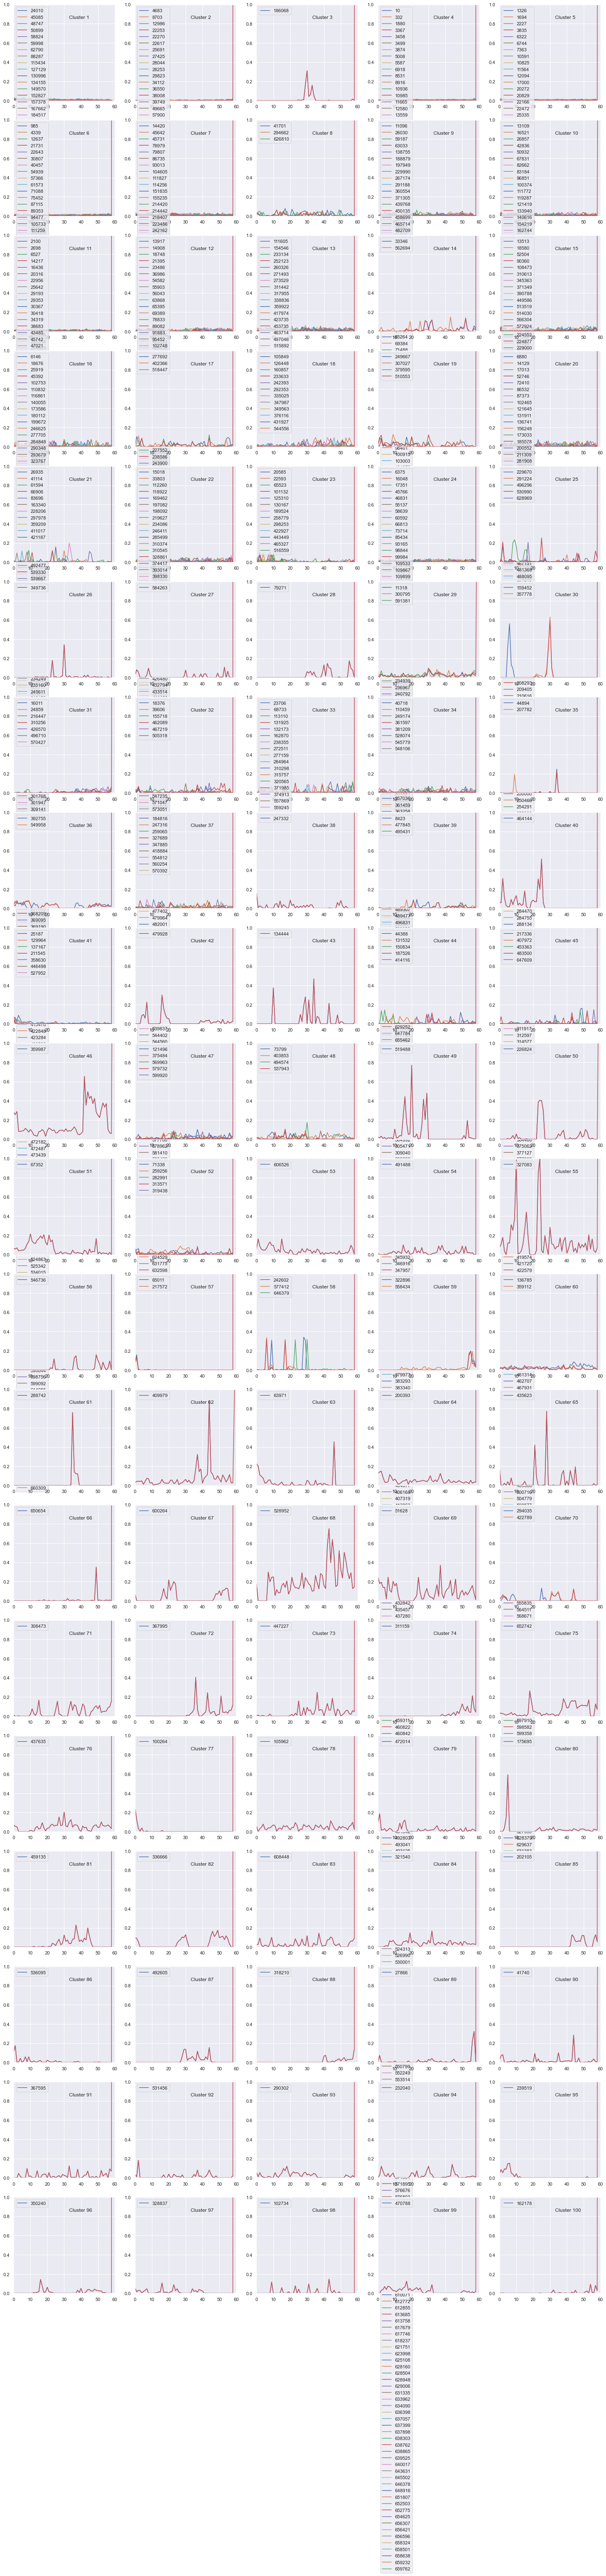

In [50]:
# Graficar la predicción de cada cluster y la real del dataset
fig, ax1 = plt.subplots(nrows = 20, ncols = 5, figsize=(25,100))
for yi in range(100):
    plt.subplot(20, 5, 1 + yi)
    sub_df = df_pivot[df_pivot['cluster'] == yi]
    sub_df.drop(['cluster'], axis=1, inplace=True)
    for index, row in sub_df.iterrows():
        plt.plot(row.values) 
    plt.legend(sub_df.index, loc ='upper left')
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, 1)
    plt.text(0.55, 0.85,'Cluster %d ' % (yi + 1),
             transform=plt.gca().transAxes)

In [51]:
# Deshacer la normalización de los centroides
for yi in range(100):

    dba_km.cluster_centers_[yi] = scaler.inverse_transform(dba_km.cluster_centers_[yi])

In [53]:
clusters = df_pivot['cluster'].unique()
df_clusters = pd.DataFrame(columns=df_pivot.columns.tolist()[:-2])
for i in range(len(clusters)):
    row = pd.Series(dba_km.cluster_centers_[i,:,0], index=df_pivot.iloc[:,:60].columns)
    df_clusters = df_clusters.append(row, ignore_index=True)
df_clusters['cluster'] = df_clusters.index
df_clusters.shape

(100, 60)

In [54]:
# Crear una serie de tiempo con los centroides
final_df = pd.melt(df_clusters, id_vars=['cluster']).sort_values(['cluster', 'variable'])
final_df.rename(columns={'variable': 'date', 'value': 'sold_quantity'}, inplace=True)
final_df

cluster       date  sold_quantity
0           0 2021-02-01       3.748092
100         0 2021-02-02       1.177778
200         0 2021-02-03       0.093496
300         0 2021-02-04       0.625000
400         0 2021-02-05       1.730435
...       ...        ...            ...
5499       99 2021-03-27      24.000000
5599       99 2021-03-28       2.000000
5699       99 2021-03-29       1.000000
5799       99 2021-03-30      21.000000
5899       99 2021-03-31       7.000000

[5900 rows x 3 columns]

## Predecir usando los centroides

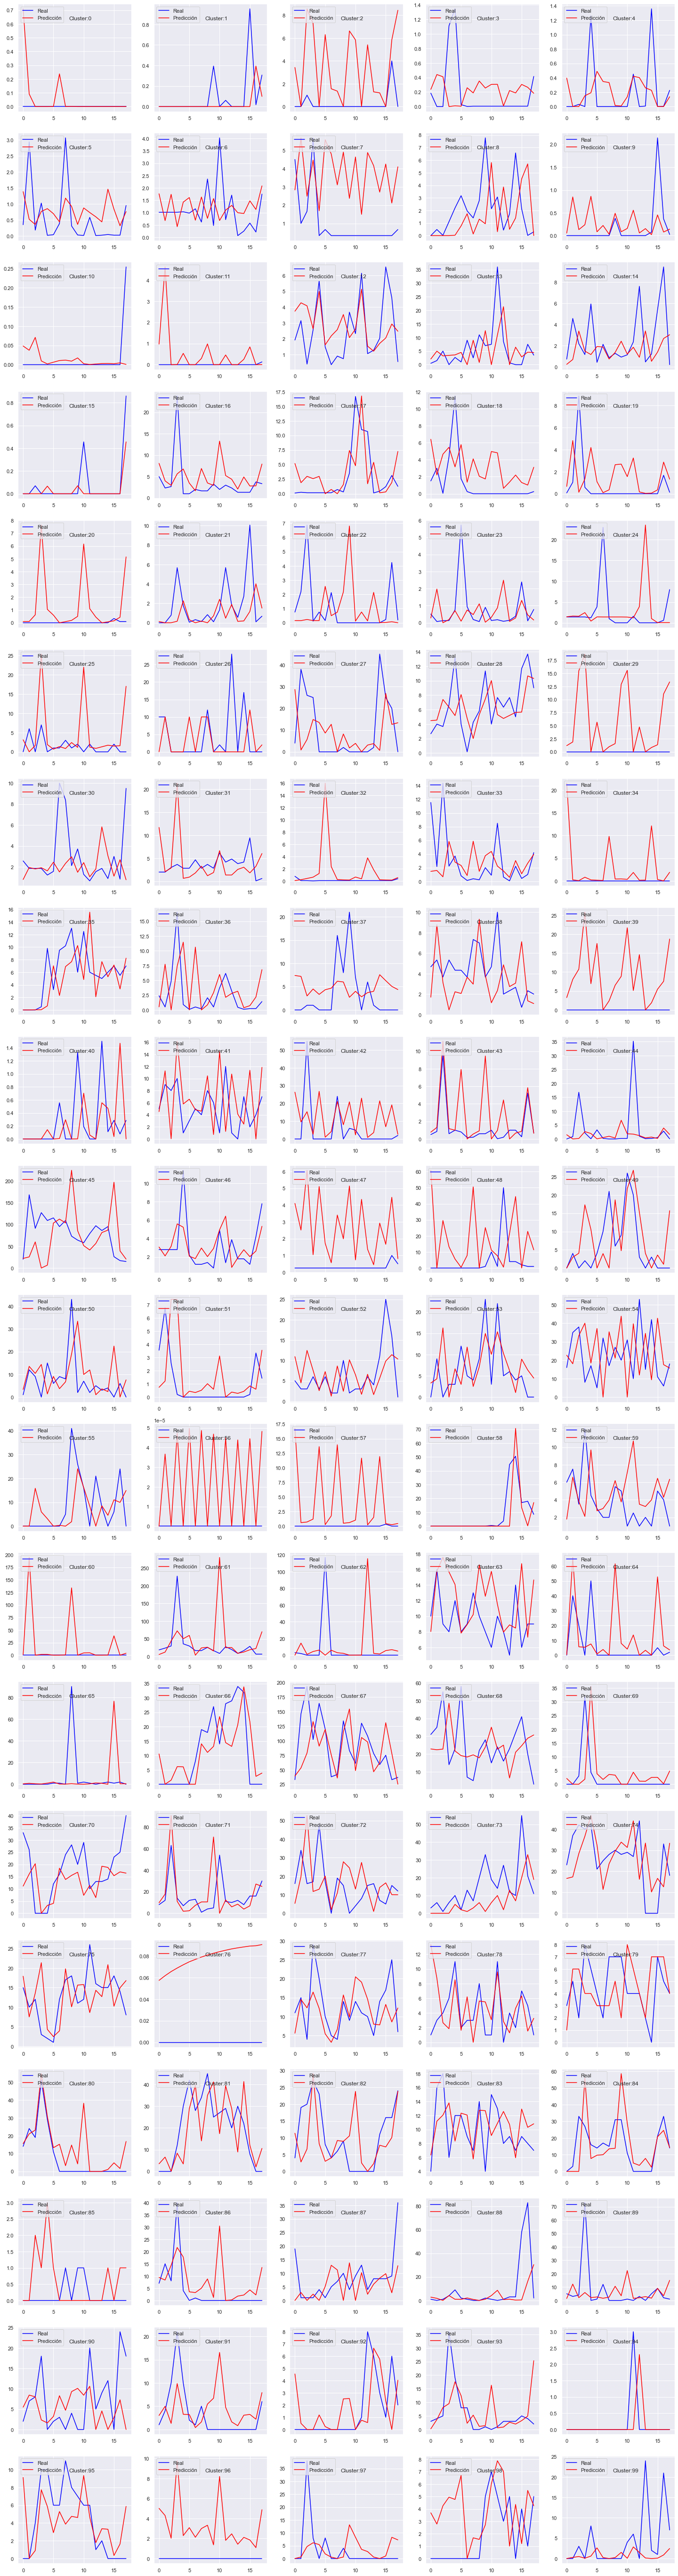

In [55]:
warnings.filterwarnings("ignore")

stock_df = pd.read_excel('dias_stock.xlsx')
vuelta = 0
n_skus = 0

# Iterar cada SKU del dataframe de stock
fig, ax1= plt.subplots(nrows = 20, ncols = 5, figsize=(25,100))
yi = 0
for cluster in df_clusters['cluster'].unique():

    series = final_df[final_df['cluster'] == cluster]
    # Dividir los datos en entrenamiento y test
    series.set_index('date', inplace=True)
    series = series['sold_quantity']
    X = series.values
    size = int(len(X) * 0.7)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    
    # Autoconfigurar el mejor modelo arima para la serie de tiempo de cada sku
    autoarima_model = auto_arima(X, start_p=0, d=0, start_q=0, max_p=10, max_d=10, max_q=10, start_P=0, D=1, start_Q=0, max_P=10, max_D=10, max_Q=10, m=7, seasonal=True, error_action='warn', trace=False, random_state=20, n_fits=50, suppress_warnings=True, stepwise=True, method='nm')
    
    # Capturar del modelo automático los parametros order y seasonal order
    order = autoarima_model.order
    s_order = autoarima_model.seasonal_order
    
    for t in range(len(test)):
        model = SARIMAX(history, order=order, seasonal_order=s_order, initialization='approximate_diffuse')
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        if yhat < 0:
            yhat = 0
        elif np.isnan(yhat):
            yhat = 0
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        # print('predicted=%f, expected=%f' % (yhat, obs))
    
    # Evaluar lo pronosticado
    rmse = sqrt(mean_squared_error(test, predictions))

    # Graficar las ventas reales vs. las predecidas
    plt.subplot(20, 5, 1 + yi)
    plt.plot(test, color='blue', label='Real')
    plt.plot(predictions, color='red', label='Predicción')
    plt.legend(loc ='upper left')
    #plt.text(0.45, 0.85,'SKU:%d-RMSE:%.3f' %(sku, rmse), transform=plt.gca().transAxes)
    plt.text(0.45, 0.85,'Cluster:%d' %(cluster), transform=plt.gca().transAxes)
    yi += 1
    
    # Pronosticar la venta de los 30 días siguientes
    forecast = model_fit.forecast(30, alpha=0.05)
    ttl = 0
    days = 0